In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import rawpy as raw
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from peakutils import peak
from skimage import measure as meas
from scipy import integrate, interpolate as interp, signal as sig, \
                  stats as stat, optimize as opt
from jupyterthemes import jtplot

In [3]:
jtplot.reset()
# plt.switch_backend('nbAgg')
plt.style.use("seaborn")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}", r"\usepackage{url}"]

## Dark frame assessment

In [66]:
cap = cv.VideoCapture('raw/KVD_7135.MOV')
dark = np.zeros((int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)), 
                 int(cap.get(cv.CAP_PROP_FRAME_WIDTH)), 
                 3))
frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if count >= frames-250:
        dark += frame
    count += 1
dark /= frames
dark = dark.astype('float32')
dark = cv.resize(dark, (6000, 4000))

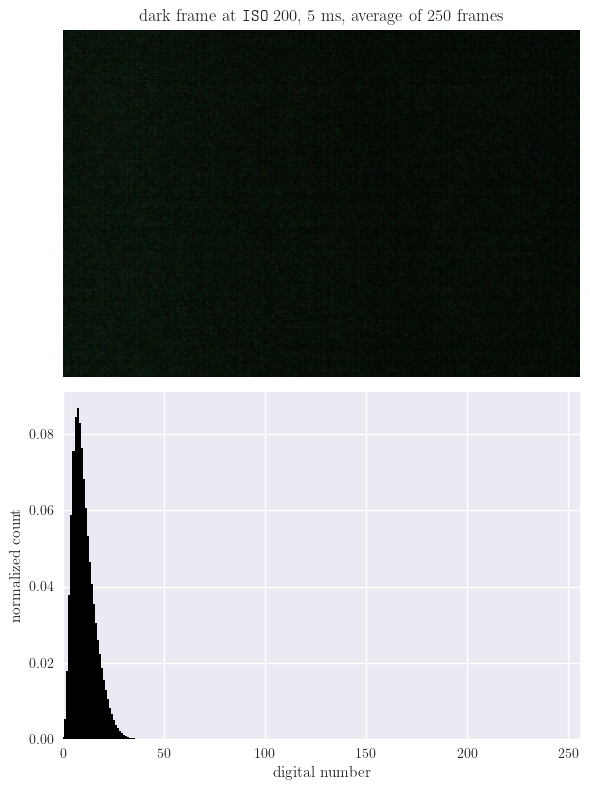

In [68]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

ax[0].imshow(dark, aspect='auto')
ax[0].set_title(r'dark frame at \texttt{ISO} 200, 5 ms, average of 250 frames')
ax[0].axis('off')

hist = np.zeros(256)
for i in range(3):
    hist += np.squeeze(cv.calcHist([(dark*255).astype('uint8')],
                                   [i], None, [256], [0, 256]))/dark.size
ax[1].bar(range(256), hist, width=1, color='k')
ax[1].set_xlim(0, 256)
ax[1].set_xlabel('digital number')
ax[1].set_ylabel('normalized count')

plt.tight_layout()
# plt.savefig('darkframe250.png', dpi=300, bbox_inches='tight')
plt.show()

## Flatness of field

In [56]:
flat_raw = raw.imread('raw/_KVD7146.NEF')
flat = flat_raw.postprocess(use_camera_wb=True,
                            output_bps=8,
                            no_auto_bright=True)
flat = cv.resize(flat, (6000, 4000))

In [58]:
def fourier(x, w, a0, a1, a2, b1, b2):
    return a0 + a1*np.cos(w*x) + b1*np.sin(w*x) + a2*np.cos(2*w*x) + b2*np.sin(2*w*x)

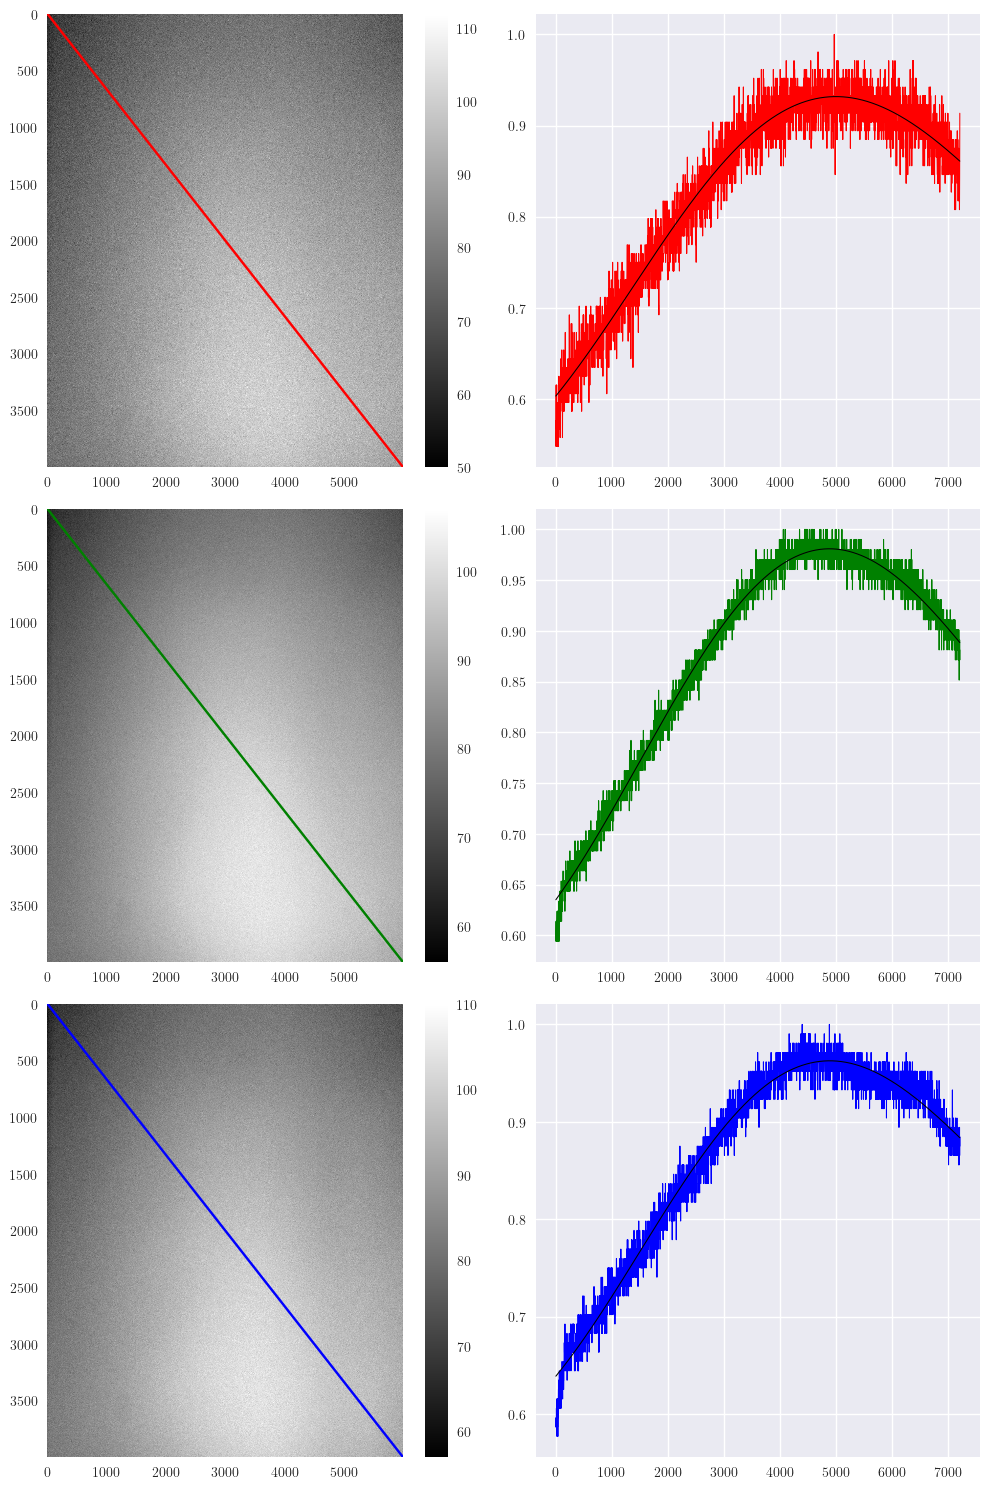

In [69]:
flat_surface_params = np.zeros((3, 6))
fig = plt.figure(figsize=(5*2, 5*3))

for i, c in zip(range(3), ['r', 'g', 'b']):
    ax = fig.add_subplot(3, 2, (2*(i+1))-1)
    im = ax.imshow(flat[:,:,i], 'gray', aspect='auto')
    ax.grid(0)
    ax.plot([0, 6000-1], [0, 4000-1], color=c)
    fig.colorbar(im)

for i, c in zip(range(3), ['r', 'g', 'b']):
    ax = fig.add_subplot(3, 2, 2*(i+1))
    trans = meas.profile_line(flat[:,:,i], (0, 0), (4000-1, 6000-1))
    trans /= trans.max()
    popt, pcov = opt.curve_fit(fourier, np.arange(len(trans)), trans, p0=np.zeros(6))
    flat_surface_params[i] = popt
    ax.plot(trans, color=c, lw=0.75)
    ax.plot(fourier(np.arange(len(trans)), *popt), 'k', lw=0.75)

plt.tight_layout()
# plt.savefig('flatfield.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
param_names = pd.Series(['w', 'a0', 'a1', 'a2', 'b1', 'b2'])
param_chan = pd.Series(['R', 'G', 'B'])
param_df = pd.DataFrame(columns=param_chan, index=param_names, data=flat_surface_params.T)
# np.save('flat_field_params.npy', popt)
# param_df.to_csv('flat_field_params.csv')
param_df

,R,G,B
w,0.000360,0.000363,0.000367
a0,0.709200,0.741978,0.751818
a1,-0.083002,-0.075842,-0.083177
a2,-0.022896,-0.031081,-0.029896
b1,0.192307,0.201291,0.173809
b2,0.009345,0.005335,0.009480


In [80]:
def imageCorrection(R, D, F):
    return (R - D)*np.mean(F - D)/(F - D)

## Mercury

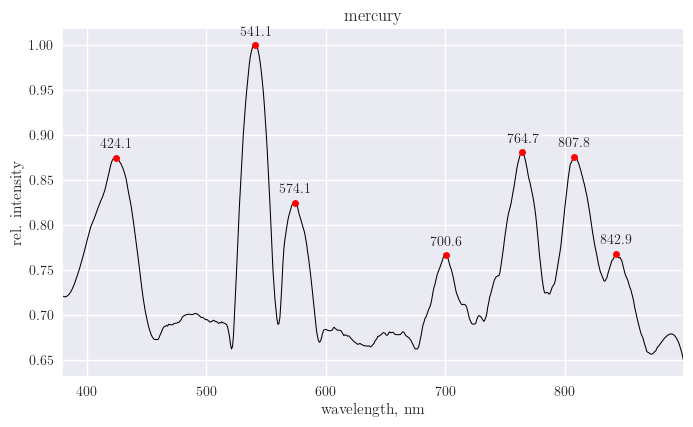

In [43]:
wavelength, intensity = np.genfromtxt('mercury.txt', unpack=True)
intensity = sig.savgol_filter(intensity, 51, 3)
intensity /= intensity.max()

pk = peak.indexes(intensity, thres=0.3, min_dist=20)

plt.plot(wavelength, intensity, 'k-', lw=0.75)
plt.plot(wavelength[pk], intensity[pk], 'ro', ms=5)
plt.xlabel('wavelength, nm')
plt.ylabel('rel. intensity')
plt.title('mercury')
for p in pk:
    plt.text(wavelength[p], intensity[p]+0.015,
             str(wavelength[p]),
             horizontalalignment='center',
             verticalalignment='center')
plt.xlim(wavelength.min(), wavelength.max())
# plt.savefig('mercury_spectra.png', dpi=300, bbox_inches='tight')
plt.show()

In [73]:
Hg_raw = raw.imread('raw/_kvd7130.nef')
Hg = Hg_raw.postprocess(use_camera_wb=True,
                        output_bps=8,
                        no_auto_bright=True)
Hg = cv.resize(Hg, (6000, 4000))
Hg = imageCorrection(Hg, dark, flat)
Hg = (Hg/Hg.max() * 255).astype('uint8')

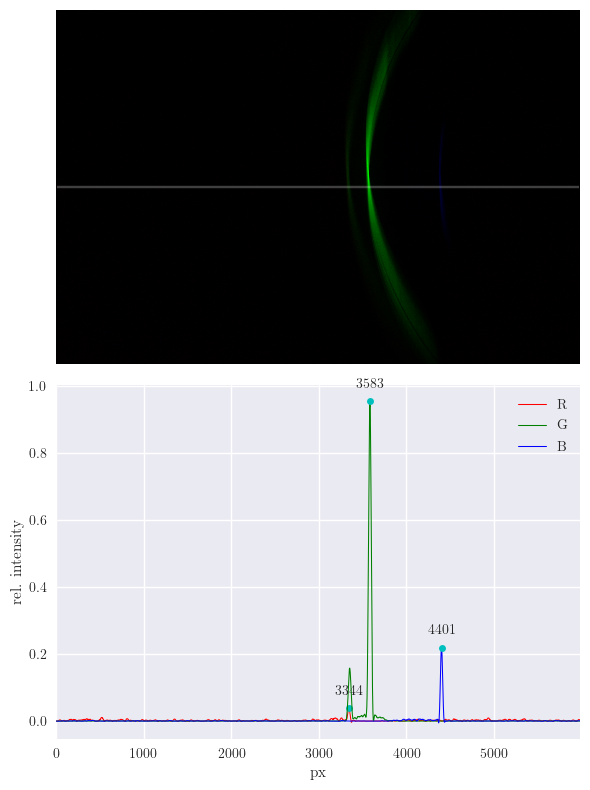

In [77]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

ax[0].imshow(Hg, aspect='auto')
linescan = (Hg.shape[0]//2, Hg.shape[1]-16)
green_max = Hg[linescan[0], :, 1].max()
ax[0].hlines(linescan[0], 0, linescan[1], 'w', alpha=0.25)
ax[0].axis('off')

for i, c in zip(range(Hg.shape[2]), ['r', 'g', 'b']):
    int_profile = Hg[linescan[0], :, i]
    int_profile = sig.savgol_filter(int_profile, 51, 3)/green_max
    pk = peak.indexes(int_profile, thres=0.5, min_dist=15)
    ax[1].plot(int_profile, color=c, lw=0.75, label=c.capitalize())
    ax[1].plot(pk, int_profile[pk], 'co', ms=5)
    for p in pk:
        plt.text(p, int_profile[p]+0.05,
                 str(p),
                 horizontalalignment='center',
                 verticalalignment='center')
ax[1].set_xlim(0, Hg.shape[1]-16)
ax[1].set_xlabel('px')
ax[1].set_ylabel('rel. intensity')
ax[1].legend()

plt.tight_layout()
# plt.savefig('Hg_linescan.png', dpi=300, bbox_inches='tight')
plt.show()

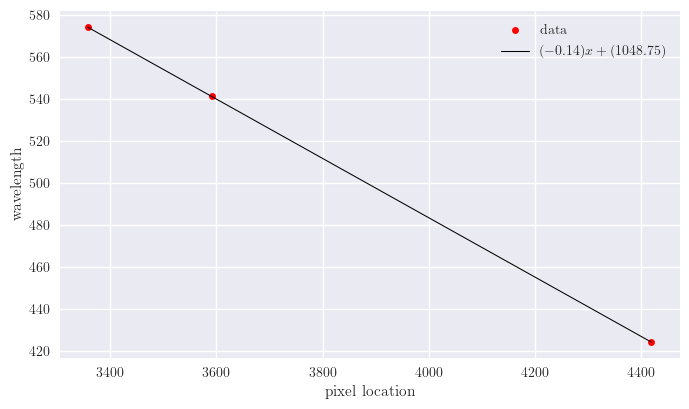

In [78]:
Hg_loc = np.array([3358, 3591, 4419])
Hg_lambda = np.array([574.1, 541.1, 424.1])

m, b, _, _, _ = stat.linregress(Hg_loc, Hg_lambda)

def cal(px):
    return m*px + b

plt.plot(Hg_loc, Hg_lambda, 'ro', ms=5, label='data')
plt.plot(Hg_loc, m*Hg_loc + b, 'k-', lw=0.75, label=r'$(%.2f)x + (%.2f)$'%(m, b))
plt.xlabel('pixel location')
plt.ylabel('wavelength')
plt.legend()
# plt.savefig('calibration.png', dpi=300, bbox_inches='tight')
plt.show()

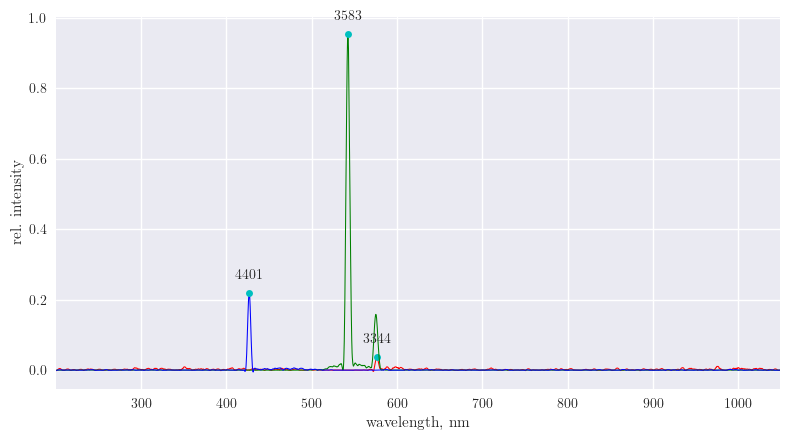

In [79]:
wavelength = cal(np.arange(Hg.shape[1]))
for i, c in zip(range(Hg.shape[2]), ['r', 'g', 'b']):
    int_profile = Hg[linescan[0], :, i]
    int_profile = sig.savgol_filter(int_profile, 51, 3)/green_max
    pk = peak.indexes(int_profile, thres=0.5, min_dist=15)
    plt.plot(wavelength, int_profile, color=c, lw=0.75, label=c.capitalize())
    plt.plot(wavelength[pk], int_profile[pk], 'co', ms=5)
    for p in pk:
        plt.text(wavelength[p], int_profile[p]+0.05,
                 str(p),
                 horizontalalignment='center',
                 verticalalignment='center')
plt.xlim(wavelength.min(), wavelength.max())
plt.xlabel('wavelength, nm')
plt.ylabel('rel. intensity')
plt.tight_layout()
# plt.savefig('Hg_calibrated.png', dpi=300, bbox_inches='tight')
plt.show()

## Broad

In [81]:
white = cv.imread('_KVD7130.png')
white = cv.cvtColor(white, cv.COLOR_BGR2RGB)
white = imageCorrection(white, dark, flat)
white = (white/white.max() * 255).astype('uint8')

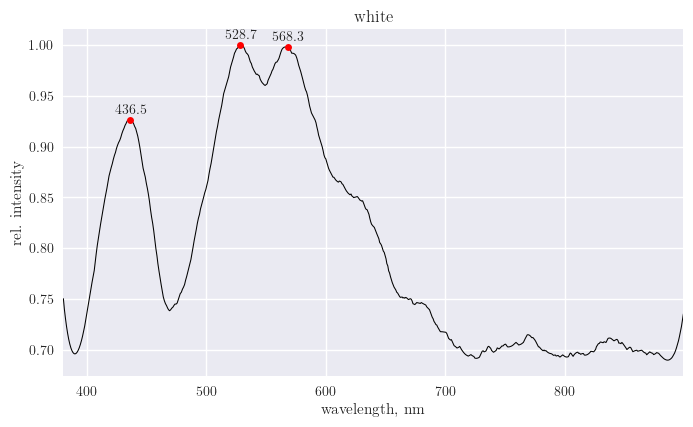

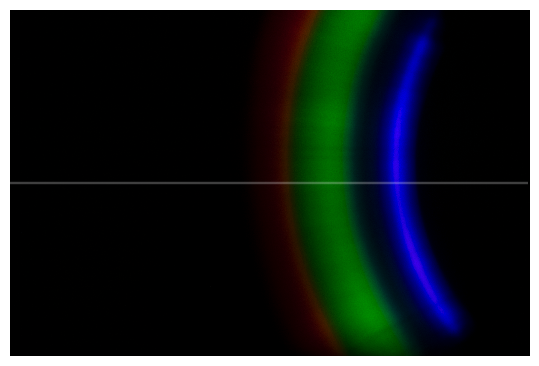

In [82]:
wavelength, intensity = np.genfromtxt('iphone_white.txt', unpack=True)
intensity = sig.savgol_filter(intensity, 51, 3)
intensity /= intensity.max()

pk = peak.indexes(intensity, thres=0.7, min_dist=30)

plt.plot(wavelength, intensity, 'k-', lw=0.75)
plt.plot(wavelength[pk], intensity[pk], 'ro', ms=5)
plt.xlabel('wavelength, nm')
plt.ylabel('rel. intensity')
plt.title('white')
for p in pk:
    plt.text(wavelength[p], intensity[p]+0.01,
             str(wavelength[p]),
             horizontalalignment='center',
             verticalalignment='center')
plt.xlim(wavelength.min(), wavelength.max())
# plt.savefig('LED_spectra.png', dpi=300, bbox_inches='tight')
plt.show()

linescan = (white.shape[0]//2, white.shape[1]-16)
plt.hlines(linescan[0], 0, linescan[1], 'w', alpha=0.25)
plt.imshow(white)
plt.axis('off')
plt.show()

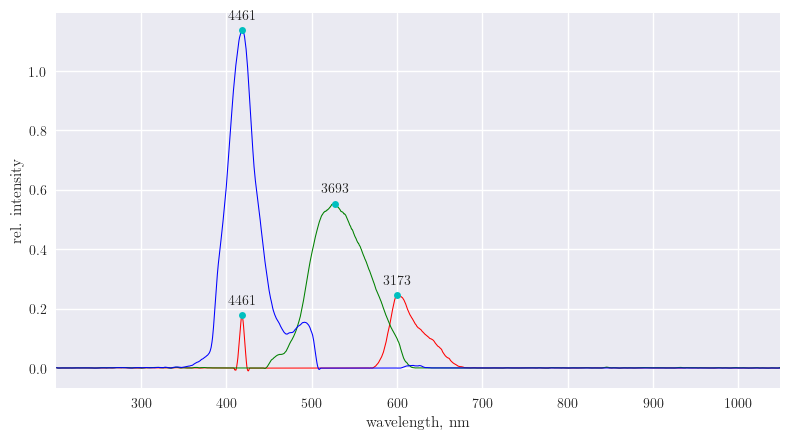

In [85]:
wavelength = cal(np.arange(white.shape[1]))
for i, c in zip(range(white.shape[2]), ['r', 'g', 'b']):
    int_profile = white[linescan[0], :, i]
    int_profile = sig.savgol_filter(int_profile, 71, 3)/green_max
    pk = peak.indexes(int_profile, thres=0.5, min_dist=200)
    plt.plot(wavelength, int_profile, color=c, lw=0.75, label=c.capitalize())
    plt.plot(wavelength[pk], int_profile[pk], 'co', ms=5)
    for p in pk:
        plt.text(wavelength[p], int_profile[p]+0.05,
                 str(p),
                 horizontalalignment='center',
                 verticalalignment='center')
plt.xlim(wavelength.min(), wavelength.max())
plt.xlabel('wavelength, nm')
plt.ylabel('rel. intensity')
plt.tight_layout()
# plt.savefig('broad_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()